In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [2]:
# get input data
deepmimo = True

function_folder = "first_deepmimo_data"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

            0         1         2         3         4         5         6  \
0    0.460487  0.793432  0.700409  0.360468  0.815099  0.724490  0.619113   
1    0.540480  0.618762  0.785914  0.494659  0.500697  0.489597  0.212646   
2    0.460209  0.521667  0.374136  0.577464  0.666319  0.471732  0.560151   
3    0.598050  0.396094  0.537069  0.756119  0.488521  0.473591  0.546774   
4    0.401408  0.273766  0.569669  0.383373  0.720012  0.569151  0.251369   
..        ...       ...       ...       ...       ...       ...       ...   
135  0.363128  0.338123  0.503536  0.328175  0.289576  0.448592  0.773523   
136  0.677361  0.283705  0.480587  0.383662  0.375413  0.624785  0.587288   
137  0.188857  0.587114  0.581141  0.446629  0.522224  0.556466  0.365749   
138  0.561732  0.589237  0.610629  0.571115  0.857121  0.282540  0.589251   
139  0.467554  0.278974  0.511157  0.691210  0.356881  0.458039  0.542283   

            7         8         9  ...      1014      1015      1016  \
0  

In [3]:
tensors['train'][1].shape

torch.Size([140, 1024])

# Evaluate KAN

In [4]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1024]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1,1,1], [1,2,1], [1, 3, 1], [1,5,1] , [1,7,1]],   #[1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 5, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]
        'kan__grid': [3,2,1],
        'kan__k': [5,2,1],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [100]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
if not deepmimo:
    grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

    # Retrieve the best parameters and best score
    grid_search.best_params_['kan__data'] = []          # remove annoying print
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    opt_params_KAN = grid_search.best_params_


In [5]:
# evaluate KAN with optimal params
if not deepmimo:
    kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=100, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

In [ ]:
if deepmimo:
    kan_model = KANModel(width=[1024, 500, 1024], grid=10, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,epochs=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 2.70e-01 | reg: 0.00e+00 | :  20%|▏| 2/10 [02:37<09:52, 74.09s/i

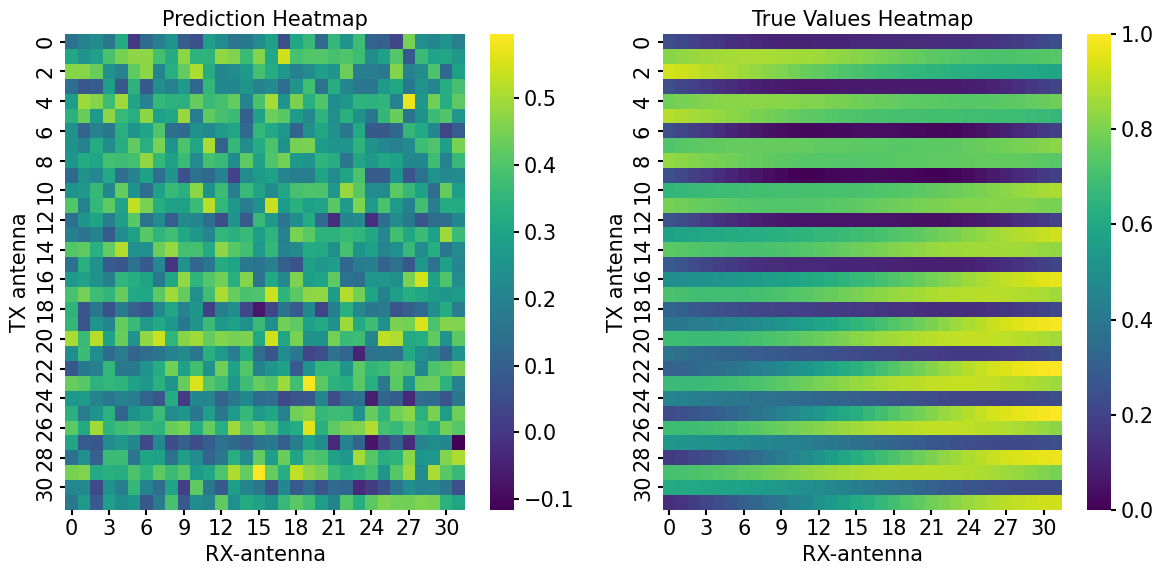

In [ ]:
# plot pred and true
if deepmimo:
    pred_sample = y_preds['preds'][5]
    true_sample = tensors['test'][1][5]
    kan_model.plot_deepmimo(true_sample=true_sample, pred_sample=pred_sample,save=False)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)

plotting noisy and true


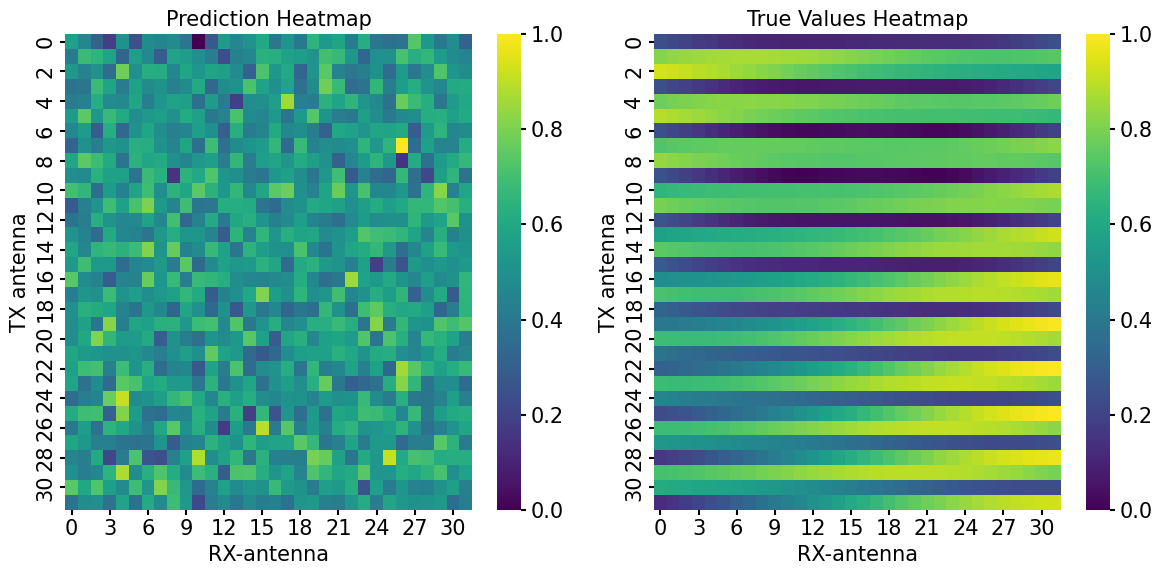

In [ ]:
# plot noise and true
if deepmimo:
    print(f"plotting noisy and true")
    pred_sample = tensors['test'][0][5]
    true_sample = tensors['test'][1][5]
    kan_model.plot_deepmimo(true_sample=true_sample, pred_sample=pred_sample,save=False, noisy=True)

In [ ]:
num_samples = tensors['test'][0].shape
noisy = tensors['test'][0] # [20, 1024]
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((noisy-true)**2, axis=1))
print(f"Average MSE per sample between noisy and true: {average_mse}")

Average MSE per sample between noisy and true: 86.26461791992188


In [ ]:
# diffrence pred and true
num_samples = tensors['test'][0].shape
preds = y_preds['preds']
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
print(f"Average MSE per sample between predicted and true for KAN: {average_mse}")

Average MSE per sample between predicted and true for KAN: 121.9702377319336


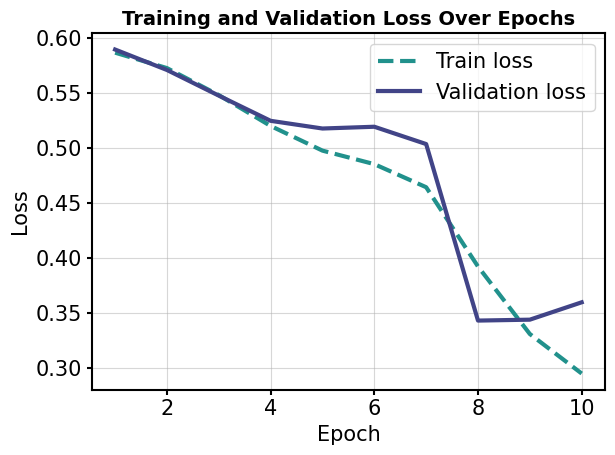

In [ ]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [ ]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[1], [2], [3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001, 0.0001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=3
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
/hom

[CV 1/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 96%|█████████▌| 96/100 [00:19<00:00,  4.18it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 100/100 [00:19<00:00,  5.11it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]

[CV 5/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


[CV 3/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

  3%|▎         | 3/100 [00:00<00:15,  6.28it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 100/100 [00:20<00:00,  4.93it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 100/100 [00:20<00:00,  4.88it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

[CV 1/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

  7%|▋         | 7/100 [00:01<00:17,  5.19it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  7%|▋         | 7/100 [00:01<00:18,  5.07it/s]

[CV 2/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 99%|█████████▉| 99/100 [00:18<00:00,  4.83it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 95%|█████████▌| 95/100 [00:18<00:00,  5.08it/s]

[CV 3/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  1%|          | 1/100 [00:00<00:12,  8.07it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 98%|█████████▊| 98/100 [00:19<00:00,  4.50it/s]

[CV 4/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 99%|█████████▉| 99/100 [00:19<00:00,  4.62it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]

[CV 5/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 98%|█████████▊| 98/100 [00:18<00:00,  3.59it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  6%|▌         | 6/100 [00:00<00:15,  6.19it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  3%|▎         | 3/100 [00:00<00:12,  7.53it/s]]

[CV 2/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 95%|█████████▌| 95/100 [00:19<00:01,  4.02it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]

[CV 4/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 12%|█▏        | 12/100 [00:02<00:19,  4.61it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  7%|▋         | 7/100 [00:01<00:16,  5.50it/s]]

[CV 1/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 98%|█████████▊| 98/100 [00:19<00:00,  5.10it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 95%|█████████▌| 95/100 [00:18<00:01,  4.92it/s]

[CV 1/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 97%|█████████▋| 97/100 [00:19<00:00,  4.82it/s]

[CV 3/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


[CV 3/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

  8%|▊         | 8/100 [00:01<00:14,  6.16it/s]

[CV 2/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

 12%|█▏        | 12/100 [00:01<00:11,  7.81it/s]

[CV 2/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

100%|██████████| 100/100 [00:08<00:00, 12.19it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()


[CV 5/5] END mlp__data={'train': (tensor([[0.4605, 0.7934, 0.7004,  ..., 0.6419, 0.6810, 0.5675],
        [0.5405, 0.6188, 0.7859,  ..., 0.4204, 0.3984, 0.4267],
        [0.4602, 0.5217, 0.3741,  ..., 0.3877, 0.4727, 0.5069],
        ...,
        [0.1889, 0.5871, 0.5811,  ..., 0.4408, 0.4751, 0.4337],
        [0.5617, 0.5892, 0.6106,  ..., 0.6765, 0.5735, 0.6452],
        [0.4676, 0.2790, 0.5112,  ..., 0.5054, 0.6353, 0.5232]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],
        [0.2265, 0.6950, 0.7340,  ..., 0.7801, 0.6472, 0.2357]])), 'test': (tensor([[0.7350, 0.4583, 0.6271,  ..., 0.5861, 0.6953, 0.4163],
        [0.3587, 0.4983, 0.8126,  ..., 0.6624, 0.4931, 0.3732],
        [0.8416, 0.3417, 0.249

100%|██████████| 100/100 [00:08<00:00, 11.47it/s]

Best Parameters: {'mlp__output_size': 1024, 'mlp__input_size': 1024, 'mlp__hidden_size': [5000], 'mlp__epochs': 100, 'mlp__deepmimo': True, 'mlp__data': []}
Best Cross-Validation Score: -0.06580365672707558


In [ ]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'],result_path=f"./results/MLP/{function_folder}")
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

 46%|████▌     | 46/100 [03:55<04:35,  5.11s/it]


KeyboardInterrupt: 

In [ ]:
# diffrence pred and true for MLP
num_samples = tensors['test'][0].shape
preds = y_preds_MLP['preds']
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
print(f"Average MSE per sample between predicted and true for MLP: {average_mse}")

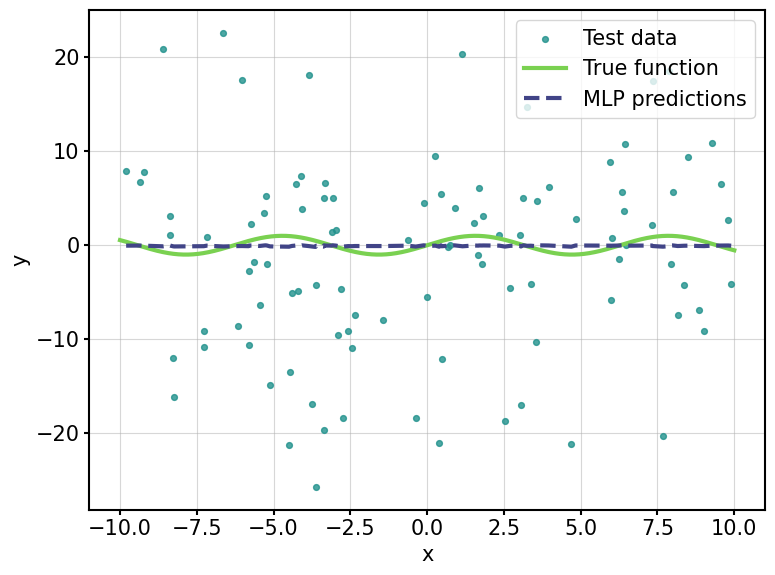

In [ ]:
# plot predictions
if deepmimo:
    pred_sample = y_preds_MLP['preds'][0]
    true_sample = tensors['test'][1][0]
    mlp_model.plot_deepmimo(pred_sample=pred_sample, true_sample=true_sample,save=True)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)

saved loss to  ./results/MLP/sin_gaussian_-23.42/loss.png
Model parameters saved to ./results/MLP/sin_gaussian_-23.42/model_params.txt


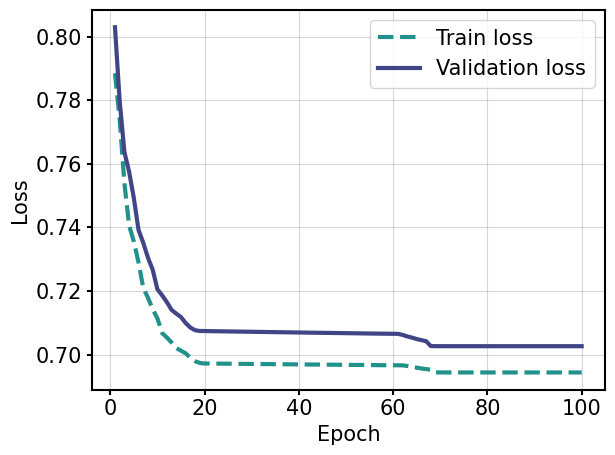

In [ ]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=True, deepmimo=deepmimo)